In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc

In [ ]:
## Global parameters
N = 100
space_range = [-1, 1]
center = np.array([0, 0, 0])
r0 = 0.7

In [3]:
def create_mesh(n_side, space_range) -> tuple[np.ndarray, tuple[np.ndarray, np.ndarray, np.ndarray]]:
    x = np.linspace(space_range[0], space_range[1], n_side)
    y = np.linspace(space_range[0], space_range[1], n_side)
    z = np.linspace(space_range[0], space_range[1], n_side)
    mesh = np.zeros((n_side, n_side, n_side))
    return mesh, np.meshgrid(x, y, z)

def show_mesh(grid, mesh, title='Mesh'):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(grid[0], grid[1], grid[2], c=mesh, alpha=0.2, s=1)
    ax.set_title(title)
    plt.show()

def show_mesh_2d(mesh, title='Mesh'):
    fig = plt.figure()
    axs = fig.subplots(1, 3)
    im = axs[0].imshow(np.sum(mesh, axis=0))
    axs[0].imshow(np.sum(mesh, axis=0))
    axs[1].imshow(np.sum(mesh, axis=1))
    axs[2].imshow(np.sum(mesh, axis=2))
    fig.colorbar(im, ax=axs, orientation='horizontal', fraction=0.02, pad=0.1)
    plt.show()


def density_distribution(grid, mesh, center):
    radial_distance = np.linalg.norm(grid - center[:, None, None, None], axis=0)
    # radial_distance = np.sqrt((grid[0] - center[0])**2 + (grid[1] - center[1])**2 + (grid[2] - center[2])**2)
    n = mesh.shape[0]//3
    distance_steps = np.linspace(0, np.max(radial_distance), n)
    density = np.zeros(n)

    for i in range(1, n):
        d_inner = distance_steps[i-1]
        d_outer = distance_steps[i]
        mask_outer = radial_distance < d_outer
        mask_inner = radial_distance > d_inner
        volume = 4/3 * np.pi * (d_outer**3 - d_inner**3)
        # print(f'Calculating density for distance {d_inner}-{d_outer}')
        # show_mesh(grid, mask_outer & mask_inner, title=f'{d_inner}-{d_outer}')
        density[i-1] = np.sum(mesh[mask_outer & mask_inner]) / volume

    return distance_steps, density

def plot_distribution(x, y, title='Density distribution'):
    plt.plot(x, y)
    plt.vlines(r0, np.min(y), np.max(y), colors='r', linestyles='dashed')
    plt.xlabel('Distance')
    plt.title(title)
    plt.show()

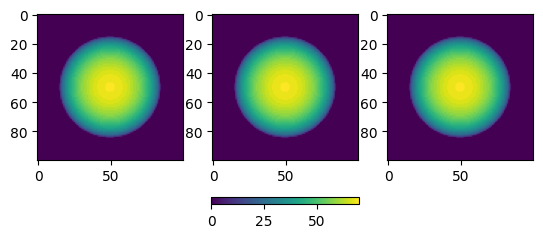

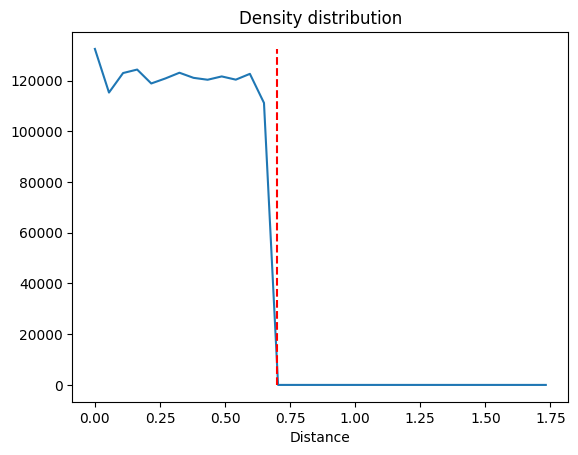

In [4]:
mesh, grid = create_mesh(N, space_range)
# show_mesh(grid, mesh, 'Initial mesh')

# linalg.norm does not work here, because we want to do it matrix-wise
radial_distance = np.sqrt((grid[0] - center[0])**2 + (grid[1] - center[1])**2 + (grid[2] - center[2])**2)

mesh[radial_distance < r0] = 1

# show_mesh(grid, mesh, 'Mesh after applying the condition')
show_mesh_2d(mesh)


distance_steps, density = density_distribution(grid, mesh, center)
plot_distribution(distance_steps, density, 'Density distribution')

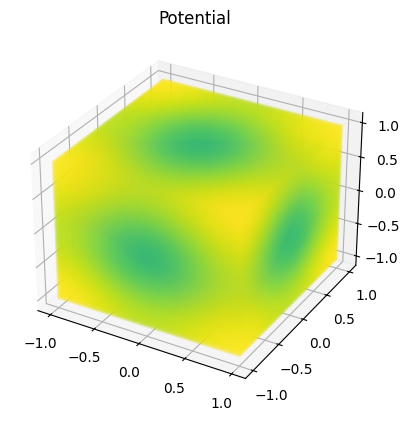

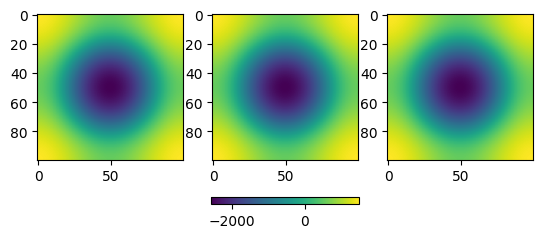

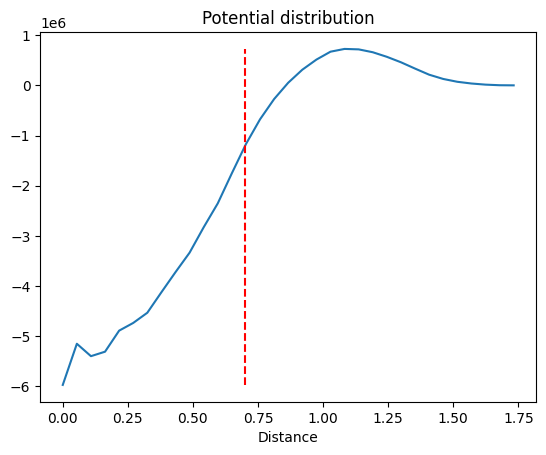

In [5]:
# Construct the mesh and grid of the fourier space mapped quantities
rho_k = np.fft.fftn(mesh)
k = np.fft.fftfreq(N, d=(space_range[1] - space_range[0]) / N)
kx, ky, kz = np.meshgrid(k, k, k)

# print(rho_k.shape, kx.shape, ky.shape, kz.shape)

# apply the poisson equation in fourier space
k_abs = np.sqrt(kx**2 + ky**2 + kz**2)
# intermediately set this to one and later on set the result back to zero
k_corrected = np.where(k_abs == 0, 1, k_abs)
phi_k = - rho_k * (4 * np.pi / k_corrected**2)
phi_k[k_abs == 0] = 0

# transform back to real space
phi = np.fft.ifftn(phi_k)
show_mesh(grid, np.real(phi), 'Potential')
show_mesh_2d(np.real(phi), 'Potential')

distance_steps, phi_d = density_distribution(grid, np.real(phi), center)
plot_distribution(distance_steps, phi_d, 'Potential distribution')

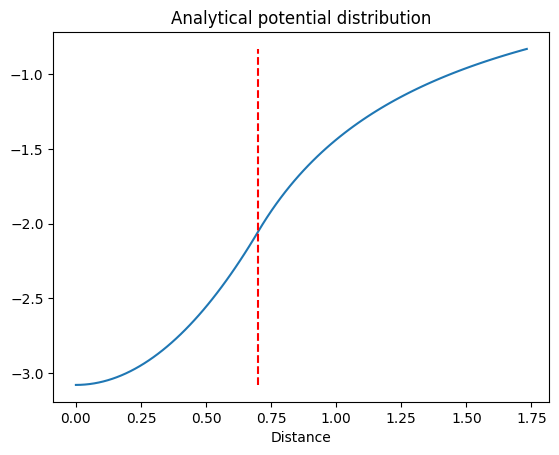

In [6]:
# analytical solution
def phi_analytical(r, r0):
    phi = np.zeros_like(r)
    phi[r < r0] = np.abs(r[r < r0]/r0)**2 - 3
    phi[r >= r0] = -2 * np.abs(r0/r[r >= r0])
    phi *= (4 * np.pi / 6) * r0**2
    return phi

distance_steps = np.linspace(0, np.max(radial_distance), N)
phi_a = phi_analytical(distance_steps, r0)
plot_distribution(distance_steps, phi_a, 'Analytical potential distribution')

In [ ]:
def acceleration(phi, grid, center, end):
    # line between center and end
    direction = (end - center / np.linalg.norm(end - center)).astype(int)
    print(direction)
    points = [center + i * direction for i in range(1, phi.shape[0]//2)]
    phi_values = phi[points]
    print(phi_values)

    a = - np.gradient(phi_values)
    return a

a = acceleration(np.real(phi), grid, center, np.array([1, 1, 1]))
